<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3176 entries, 0 to 3175
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   overall         3176 non-null   float64
 1   verified        3176 non-null   bool   
 2   reviewTime      3176 non-null   object 
 3   reviewerID      3176 non-null   object 
 4   asin            3176 non-null   object 
 5   style           3107 non-null   object 
 6   reviewerName    3176 non-null   object 
 7   reviewText      3160 non-null   object 
 8   summary         3176 non-null   object 
 9   unixReviewTime  3176 non-null   int64  
 10  vote            297 non-null    object 
 11  image           106 non-null    object 
dtypes: bool(1), float64(1), int64(1), object(9)
memory usage: 276.2+ KB
None
   overall  verified  reviewTime     reviewerID        asin  \
0      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K   
1      5.0      True  09 4, 2015  ALJ66O1Y6SLHA  B000K2PJ4K

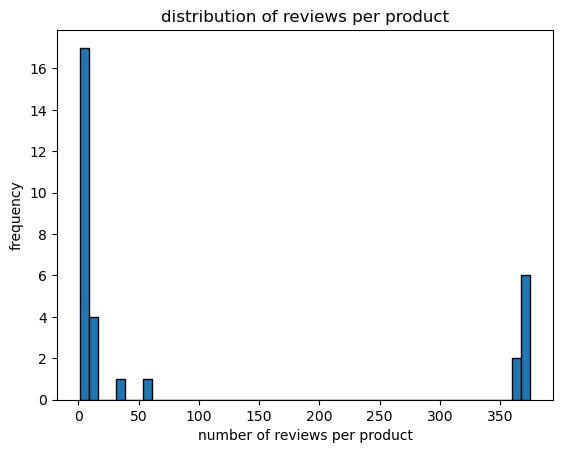

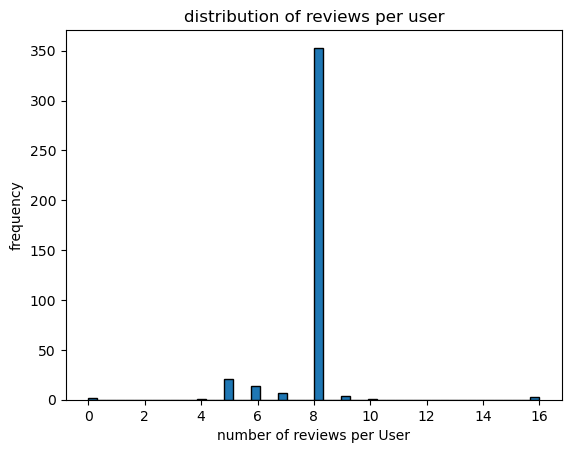

average review length (words): 24.71
max review length: 272
min review length: 0


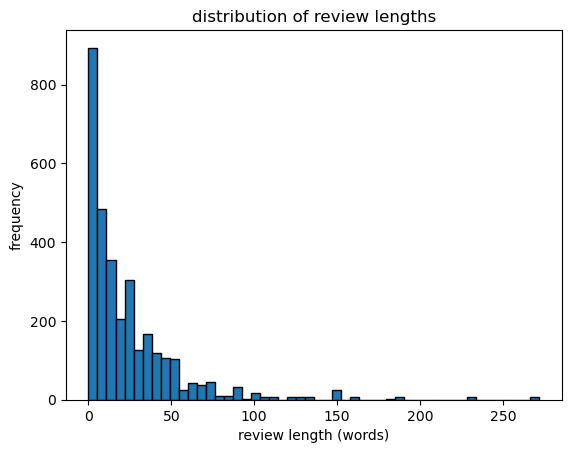

initial dataset size: 3176
number of duplicate reviews: 167
dataset size after removing duplicates: 3087


In [2]:
# -*- coding: utf-8 -*-
"""
Created on Thu Feb 13 18:21:29 2025

@author: coles
"""

#PROJECT PHASE 1
#GROUP 1 (AMAZON FASHION)

import pandas as pd
import json
import matplotlib.pyplot as plt

#DELIVERABLE 1)

#creating a function to load line-delimited json
def load_json_lines(path):
    data = []
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            try:
                data.append(json.loads(line))
            except json.JSONDecodeError as e:
                print(f"error decoding json at line {len(data)}: {e}")

    return pd.DataFrame(data)

#loading the dataset (adjust the path based on where you store it locally on your end)
file_path = "C:/Users/coles/AMAZON_FASHION_5.json"
df = load_json_lines(file_path)

#showing some basic dataset info
print(df.info())
print(df.head())

#basic statistics of the dataset (A)
print(f"total reviews: {len(df)}")
print(f"total unique products: {df['asin'].nunique()}")
print(f"total unique users: {df['reviewerID'].nunique()}")
print(f"average rating: {df['overall'].mean():.2f}")
print(df['overall'].value_counts(normalize=True) * 100)

#distribution of reviews per product (B & C)
reviews_per_product = df.groupby("asin")["reviewText"].count()
plt.hist(reviews_per_product, bins=50, edgecolor="black")
plt.xlabel("number of reviews per product")
plt.ylabel("frequency")
plt.title("distribution of reviews per product")
plt.show()

#distribution of reviews per user (D)
reviews_per_user = df.groupby("reviewerID")["reviewText"].count()
plt.hist(reviews_per_user, bins=50, edgecolor="black")
plt.xlabel("number of reviews per User")
plt.ylabel("frequency")
plt.title("distribution of reviews per user")
plt.show()

#review length analysis (E & F)
df["review_length"] = df["reviewText"].apply(lambda x: len(str(x).split()) if pd.notna(x) else 0)
print(f"average review length (words): {df['review_length'].mean():.2f}")
print(f"max review length: {df['review_length'].max()}")
print(f"min review length: {df['review_length'].min()}")
plt.hist(df["review_length"], bins=50, edgecolor="black")
plt.xlabel("review length (words)")
plt.ylabel("frequency")
plt.title("distribution of review lengths")
plt.show()

#checking for duplicates and dropping duplicates (G) (this could be moved to the front
#of the script so that the duplicates are removed first before other analysis, up
#to you guys)
print(f"initial dataset size: {len(df)}")
duplicates = df[df.duplicated(subset=["reviewText", "reviewerID", "asin"], keep=False)]
print(f"number of duplicate reviews: {len(duplicates)}")
df = df.drop_duplicates(subset=["reviewText", "reviewerID", "asin"], keep='first')
#updated dataset size after removing duplicates
print(f"dataset size after removing duplicates: {len(df)}")
